Some sources:

* Gensim LDA: https://radimrehurek.com/gensim/models/ldamodel.html
* Misc clustering with Python: http://brandonrose.org/clustering
* Scikit LDA: http://scikit-learn.org/0.16/modules/generated/sklearn.lda.LDA.html
* Scikit NMF: http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html
* WMD in Python: http://vene.ro/blog/word-movers-distance-in-python.html
* Original WMD paper: http://jmlr.org/proceedings/papers/v37/kusnerb15.pdf

# Make word-doc matrix

In [1]:
import datetime as dt
import os
import time

In [2]:
from cltk.corpus.greek.tlg.parse_tlg_indices import get_epithet_index
from cltk.corpus.greek.tlg.parse_tlg_indices import get_epithets
from cltk.corpus.greek.tlg.parse_tlg_indices import select_authors_by_epithet
from cltk.corpus.greek.tlg.parse_tlg_indices import get_epithet_of_author
from cltk.corpus.greek.tlg.parse_tlg_indices import get_id_author
from cltk.stop.greek.stops import STOPS_LIST as greek_stops
from cltk.tokenize.word import nltk_tokenize_words

from greek_accentuation.characters import base

import pandas  # pip install pandas

from sklearn.decomposition import NMF  # pip install scikit-learn scipy
from sklearn.externals import joblib
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

In [3]:
def stream_lemmatized_files(corpus_dir, reject_none_epithet=False, reject_chars_less_than=None):
    # return all docs in a dir; parameters for removing by None epithet and short texts
    user_dir = os.path.expanduser('~/cltk_data/user_data/' + corpus_dir)
    files = os.listdir(user_dir)
    
    map_id_author = get_id_author()

    for file in files:
        filepath = os.path.join(user_dir, file)
        file_id = file[3:-4]
        author = map_id_author[file_id]

        if reject_none_epithet:
            # get id numbers and then epithets of each author
            author_epithet = get_epithet_of_author(file_id)
            if not author_epithet:
                continue

        with open(filepath) as fo:
            
            text = fo.read()
            
            if reject_chars_less_than:
                if len(text) < reject_chars_less_than:
                    continue
            
            yield file_id, author, text

In [4]:
t0 = dt.datetime.utcnow()

id_author_text_list = []
for tlg_id, author, text in stream_lemmatized_files('tlg_lemmatized_no_accents_no_stops', 
                                    reject_none_epithet=True,
                                    reject_chars_less_than=500):
    id_author_text_list.append((tlg_id, author, text))

print('... finished in {}'.format(dt.datetime.utcnow() - t0))
print('Number of texts:', len(id_author_text_list))

Lepidus Hist.
Melito Trag.
[Polyidus] Trag.
Archippus Comic.
Martyrium Potamiaenae Et Basilidis
Acta Phileae
Menecrates Hist.
Marinus Phil.
Troilus Soph.
Apollinaris Theol.
Antileon Hist.
Hermas Scr. Eccl., Pastor Hermae
Agatharchides Geogr.
Mnaseas Perieg.
Pausaniae I Et Xerxis Epistulae
Philoxenus Lyr.
Boethus Phil.
Timesitheus Trag.
Scylitzes Continuatus
Zenothemis Geogr.
Apocalypsis Esdrae
Joannes Actuarius Med.
Cephalion Hist. et Rhet.
Polycharmus Hist.
Stephanus Med.
Alcman Lyr.
[Astrampsychus Magus] Onir.
Archelaus Paradox.
Eusebius Scr. Eccl.
Melanthius Trag.
Anonymus De Metrorum Ratione
Tryphon II Gramm.
Paeon Hist.
Cratinus Comic.
Pappus Math.
Apollodorus Comic.
Theon Gramm.
Joannes Gramm. et Theol.
Pseudo-Polemon
Marcus Antonius Polemon Soph.
[Dionysius Scymnaeus] Trag. vel Comic.
Socrates Hist.
Laonicus Chalcocondyles Hist.
Simias Gramm.
Menander Protector Hist.
Epitaphium Abercii
Sosiphanes Trag.
Dionysius Geogr.
Asclepiades Gramm. et Hist.
Acta Eupli
Philetaerus Comic.
Si

In [5]:
# view all epithets:
get_epithets()

['Alchemistae',
 'Apologetici',
 'Astrologici',
 'Astronomici',
 'Atticistae',
 'Biographi',
 'Bucolici',
 'Choliambographi',
 'Chronographi',
 'Comici',
 'Doxographi',
 'Elegiaci',
 'Epici/-ae',
 'Epigrammatici/-ae',
 'Epistolographi',
 'Geographi',
 'Geometri',
 'Gnomici',
 'Gnostici',
 'Grammatici',
 'Hagiographi',
 'Historici/-ae',
 'Hymnographi',
 'Iambici',
 'Lexicographi',
 'Lyrici/-ae',
 'Mathematici',
 'Mechanici',
 'Medici',
 'Mimographi',
 'Musici',
 'Mythographi',
 'Nomographi',
 'Onirocritici',
 'Oratores',
 'Paradoxographi',
 'Parodii',
 'Paroemiographi',
 'Periegetae',
 'Philologi',
 'Philosophici/-ae',
 'Poetae',
 'Poetae Didactici',
 'Poetae Medici',
 'Poetae Philosophi',
 'Polyhistorici',
 'Rhetorici',
 'Scriptores Ecclesiastici',
 'Scriptores Erotici',
 'Scriptores Fabularum',
 'Scriptores Rerum Naturalium',
 'Sophistae',
 'Tactici',
 'Theologici',
 'Tragici']

In [6]:
t0 = dt.datetime.utcnow()

# tf-idf features
n_samples = 2000
n_features = 1000  # TODO: increase
n_topics = len(get_epithets())  # 55
n_top_words = 20

tfidf_vectorizer = TfidfVectorizer(max_df=1.0, 
                                   min_df=1,
                                   max_features=n_features,
                                   stop_words=None)
texts_list = [t[2] for t in id_author_text_list]
tfidf = tfidf_vectorizer.fit_transform(texts_list)

# save features
vector_fp = os.path.expanduser('~/cltk_data/user_data/tlg_lemmatized_no_accents_no_stops_set_reduction_tfidf_{0}features.pickle'.format(n_features))
joblib.dump(tfidf, vector_fp)

print('... finished in {}'.format(dt.datetime.utcnow() - t0))
# time on good server:
# 1000 features: 0:01:22

... finished in 0:01:01.454532


# Run model

In [7]:
t0 = dt.datetime.utcnow()

print("Fitting the NMF model with tf-idf features, "
      "n_samples=%d and n_features=%d..."
      % (n_samples, n_features))
nmf = NMF(n_components=n_topics, random_state=1,
          alpha=.1, l1_ratio=.5).fit(tfidf)

# save model
nmf_fp = os.path.expanduser('~/cltk_data/user_data/tlg_lemmatized_no_accents_no_stops_set_reduction_tfidf_{0}features_nmf.pickle'.format(n_features))
joblib.dump(nmf, nmf_fp)

print('... finished in {}'.format(dt.datetime.utcnow() - t0))

Fitting the NMF model with tf-idf features, n_samples=2000 and n_features=1000...
... finished in 0:00:08.711757


In [8]:
def print_top_words(model, feature_names, n_top_words):
    for topic_id, topic in enumerate(model.components_):
        print('Topic #{}:'.format(int(topic_id)))
        print(''.join([feature_names[i] + ' ' + str(round(topic[i], 2))
              +' | ' for i in topic.argsort()[:-n_top_words - 1:-1]]))
        print()

In [9]:
print("Topics in NMF model:")
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

print_top_words(nmf, tfidf_feature_names, n_top_words)

Topics in NMF model:
Topic #0:
ειμι 2.4 | ου 2.38 | τος 1.2 | αυ 0.97 | εχω 0.86 | τας 0.62 | αλλ 0.5 | εγω 0.42 | ποιεω 0.4 | δεω1 0.39 | τουτων 0.38 | ωσπερ 0.36 | εαυτου 0.36 | πα 0.35 | οσος 0.32 | φημι 0.32 | ουδεν 0.31 | ειπον 0.31 | καθ 0.31 | ος 0.3 | 

Topic #1:
αυ 3.02 | τος 2.96 | αυτον 0.4 | αυτην 0.26 | αυτους 0.26 | τας 0.23 | πολιν 0.16 | εκει 0.16 | γυνη 0.16 | εαυτου 0.15 | τοτε 0.15 | εγενετο 0.14 | πολυς 0.14 | ιημι 0.14 | εχω 0.14 | τουτου 0.13 | ερχομαι 0.13 | πολεως 0.13 | μετ 0.12 | αναιρεω 0.12 | 

Topic #2:
φησι 1.13 | φημι 1.08 | φησιν 0.91 | ιστορεω 0.66 | ειμι 0.63 | λεγει 0.42 | καλεω 0.37 | γενεσθαι 0.26 | ιημι 0.24 | προτερος 0.24 | αθηνη 0.23 | αυτην 0.21 | διος 0.21 | αυτον 0.21 | λεγεται 0.2 | φασι 0.19 | υστερος 0.18 | γεγονεναι 0.18 | φασιν 0.17 | ιερον 0.16 | 

Topic #3:
εγω 3.08 | νυ 0.42 | εμεω 0.33 | αλλ 0.29 | ου 0.25 | εμοι 0.25 | εμε 0.23 | παρ 0.21 | ταυτ 0.2 | οιδα 0.19 | πως 0.18 | ουδεν 0.15 | ειδον 0.15 | σοι 0.14 | σευω 0.14 | ουδ 0.13 |

In [10]:
tfidf.shape

(1143, 1000)

In [11]:
doc_topic_distrib = nmf.transform(tfidf)  # numpy.ndarray

In [12]:
doc_topic_distrib.shape

(1143, 55)

In [13]:
df = pandas.DataFrame(doc_topic_distrib)

In [16]:
len(id_author_text_list)

1143

In [22]:
authors_in_order = {index:_tuple[1] for index, _tuple in enumerate(id_author_text_list)}
print(len(authors_in_order))

1143


In [23]:
df = df.rename(authors_in_order)

Questions:

* to what topic does each author most belong? (and how to determine cutoff?)
* what authors most exemplify a topic?

In [27]:
df

,0,1,2,3,4,5,6,7,8,9,...,45,46,47,48,49,50,51,52,53,54
Lepidus Hist.,0.004470,0.058953,0.000000,0.000000,0.030413,0.000000,0.126143,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Archippus Comic.,0.036485,0.003721,0.000000,0.060426,0.017456,0.004729,0.000000,0.000000,0.025630,0.000000,...,0.000000,0.000000,0.000000,0.046645,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Menecrates Hist.,0.027667,0.087828,0.018969,0.000000,0.000000,0.010514,0.000000,0.000000,0.000000,0.026474,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Marinus Phil.,0.114863,0.023485,0.000000,0.011659,0.000000,0.000000,0.000000,0.000000,0.000000,0.021727,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.002739,0.000000
Troilus Soph.,0.121835,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.065292,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.010258,0.000000,0.000000,0.000000
Apollinaris Theol.,0.100538,0.030036,0.027692,0.000000,0.000000,0.250553,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
"Hermas Scr. Eccl., Pastor Hermae",0.062144,0.101339,0.024235,0.036189,0.000000,0.109482,0.000000,0.000000,0.023987,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Agatharchides Geogr.,0.131793,0.021604,0.033020,0.010971,0.010642,0.000000,0.000616,0.000164,0.063735,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Mnaseas Perieg.,0.047347,0.023791,0.158936,0.003979,0.042843,0.011660,0.088292,0.015780,0.036570,0.001092,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Philoxenus Lyr.,0.039898,0.022443,0.000000,0.008954,0.042070,0.000000,0.000000,0.050953,0.032228,0.000000,...,0.000000,0.000000,0.010190,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [28]:
# for each topic (col), which author (row) has the highest value?
# TODO: get top 5 authors

for count in range(n_topics):
    print('Top author of topic {0}: {1}'.format(count, df[count].idxmax()))

Top author of topic 0: Joannes Rhet.
Top author of topic 1: Cephalion Hist. et Rhet.
Top author of topic 2: Dei(l)ochus Hist.
Top author of topic 3: Theodorus Epist.
Top author of topic 4: Quintus Epic.
Top author of topic 5: Ignatius Scr. Eccl.
Top author of topic 6: Capito Hist.
Top author of topic 7: Heliodorus Trag.
Top author of topic 8: Hippias Hist.
Top author of topic 9: Theognostus Gramm.
Top author of topic 10: Euclides Geom.
Top author of topic 11: [Callicratidas] Phil.
Top author of topic 12: Cleopatra Alchem.
Top author of topic 13: Manetho Hist.
Top author of topic 14: [Ctesiphon] Hist.
Top author of topic 15: Joannes Epiphaniensis Hist.
Top author of topic 16: Teucer Astrol.
Top author of topic 17: Carneiscus Phil.
Top author of topic 18: Philodamus Lyr.
Top author of topic 19: Hecataeus Hist.
Top author of topic 20: Anaximenes Phil.
Top author of topic 21: Timaeus Praxidas Astrol.
Top author of topic 22: Paulus Med.
Top author of topic 23: Lesbonax Gramm.
Top author of 

In [29]:
# Now, transpose df and get top topic of each author
# for each topic (col), which author (row) has the highest value?
# TODO: get top 5 authors
df_t = df.T

In [31]:
#df_t.head(10)
df_t

,Lepidus Hist.,Archippus Comic.,Menecrates Hist.,Marinus Phil.,Troilus Soph.,Apollinaris Theol.,"Hermas Scr. Eccl., Pastor Hermae",Agatharchides Geogr.,Mnaseas Perieg.,Philoxenus Lyr.,...,Machon Comic.,Diodorus Comic.,Thales Phil.,Antiphon Soph.,Hesiodus Epic.,Marcus Aurelius Antoninus Imperator Phil.,Menodotus Hist.,Autolycus Astron.,[Eurytus] Phil.,Nausicrates Comic.
0,0.004470,0.036485,0.027667,0.114863,0.121835,0.100538,0.062144,0.131793,0.047347,0.039898,...,0.110981,0.066665,0.107781,0.147465,0.021797,0.168228,0.067855,0.024217,0.064872,0.017516
1,0.058953,0.003721,0.087828,0.023485,0.000000,0.030036,0.101339,0.021604,0.023791,0.022443,...,0.030100,0.000000,0.023248,0.000000,0.022842,0.004442,0.050413,0.000394,0.000000,0.046808
2,0.000000,0.000000,0.018969,0.000000,0.000000,0.027692,0.024235,0.033020,0.158936,0.000000,...,0.039987,0.000000,0.057807,0.000000,0.010124,0.000000,0.109941,0.000000,0.000000,0.000000
3,0.000000,0.060426,0.000000,0.011659,0.000000,0.000000,0.036189,0.010971,0.003979,0.008954,...,0.053363,0.003660,0.004306,0.002308,0.000000,0.006228,0.028059,0.000000,0.003075,0.000000
4,0.030413,0.017456,0.000000,0.000000,0.000000,0.000000,0.000000,0.010642,0.042843,0.042070,...,0.000000,0.018830,0.001287,0.000000,0.312191,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.000000,0.004729,0.010514,0.000000,0.000000,0.250553,0.109482,0.000000,0.011660,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000120,0.000000,0.000231,0.000000,0.000000,0.000000
6,0.126143,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000616,0.088292,0.000000,...,0.000000,0.036486,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000164,0.015780,0.050953,...,0.000000,0.000000,0.068443,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,0.000000,0.025630,0.000000,0.000000,0.000000,0.000000,0.023987,0.063735,0.036570,0.032228,...,0.000000,0.068430,0.000000,0.000000,0.000000,0.000000,0.000000,0.005244,0.064412,0.000000
9,0.000000,0.000000,0.026474,0.021727,0.065292,0.000000,0.000000,0.000000,0.001092,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.025806,0.000000,0.000000,0.088290,0.000000


In [32]:
map_name_epithet_id = {}
for curr_name in df_t.columns:
    print(curr_name)
    try:
        top_topic = int(df_t[curr_name].idxmax())
    except TypeError:  # there are some duplicate names, just take one value for now
        top_topic = int(df_t[curr_name].idxmax().iloc[0])    
    print('    NMF topic:', top_topic)
    for _id, name in get_id_author().items():
        if curr_name == name:
            epithet = get_epithet_of_author(_id)
            print('    Traditional epithet:', epithet)
            map_name_epithet_id[name] = {'id': _id,
                                        'top_topic': top_topic,
                                        'epithet': epithet}
    print()

Lepidus Hist.
    NMF topic: 6
    Traditional epithet: Historici/-ae

Archippus Comic.
    NMF topic: 18
    Traditional epithet: Comici

Menecrates Hist.
    NMF topic: 1
    Traditional epithet: Historici/-ae
    Traditional epithet: Historici/-ae
    Traditional epithet: Historici/-ae
    Traditional epithet: Historici/-ae
    Traditional epithet: Historici/-ae

Marinus Phil.
    NMF topic: 0
    Traditional epithet: Philosophici/-ae

Troilus Soph.
    NMF topic: 0
    Traditional epithet: Sophistae

Apollinaris Theol.
    NMF topic: 5
    Traditional epithet: Theologici

Hermas Scr. Eccl., Pastor Hermae
    NMF topic: 5
    Traditional epithet: Scriptores Ecclesiastici

Agatharchides Geogr.
    NMF topic: 0
    Traditional epithet: Geographi

Mnaseas Perieg.
    NMF topic: 2
    Traditional epithet: Periegetae

Philoxenus Lyr.
    NMF topic: 17
    Traditional epithet: Lyrici/-ae
    Traditional epithet: Lyrici/-ae

Boethus Phil.
    NMF topic: 0
    Traditional epithet: Philosoph

Now let's look at the variations of the respective clusters, nmf topic and epithets

* Question: Which topics are found within each epithet?
* Question: Which epithets are found within each topic? And how many?

In [34]:
# Group by epithet, collect topics
# {<epithet>: [<topics>]}
from collections import defaultdict

map_epithet_topics = defaultdict(list)
for name, _dict in map_name_epithet_id.items():
    epithet = _dict['epithet']
    top_topic = _dict['top_topic']
    map_epithet_topics[epithet].append(top_topic)

In [35]:
# import pprint
# pp = pprint.PrettyPrinter(indent=4)
# pp.pprint(dict(map_epithet_topics))
print(dict(map_epithet_topics))

{'Geographi': [48, 5, 25, 16, 0, 47, 6, 6, 0, 42, 6], 'Scriptores Erotici': [0, 17, 0, 37, 0, 0, 0, 0], 'Astrologici': [0, 21, 21, 0, 21, 21, 21, 16, 21, 5, 21, 1, 21, 21], 'Atticistae': [0, 23, 23, 49], 'Grammatici': [1, 21, 8, 6, 14, 13, 23, 6, 0, 15, 0, 3, 51, 25, 0, 23, 23, 51, 0, 9, 23, 0, 9, 35, 0, 9, 4, 4, 0, 20, 9, 41, 51, 2, 23, 23, 26, 9, 12, 9, 23, 0, 2, 2, 50, 9, 53, 18, 0, 0, 0, 0, 4, 23, 35, 9, 8, 0, 22, 25, 5, 50, 18, 23, 1], 'Tactici': [47, 1, 0, 47, 0, 1], 'Lyrici/-ae': [53, 29, 4, 4, 4, 17, 48, 37, 17, 3, 39, 17, 28, 4, 4, 4, 17, 4, 50, 21, 4, 37, 53, 3, 4, 28, 54, 46, 44, 38, 20], 'Mythographi': [1, 1, 2, 1, 44, 0, 1], 'Sophistae': [0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 32, 0, 0, 9, 1, 0, 0, 0, 54, 33, 0, 0, 0, 3, 0, 0, 0, 48, 0, 9, 0, 0, 3, 32, 23, 0], 'Hagiographi': [0, 10], 'Hymnographi': [5], 'Paroemiographi': [0, 0, 0, 0, 0], 'Apologetici': [5, 0, 5, 31, 0, 5, 5, 5, 0], 'Epistolographi': [3, 5, 15, 0, 15, 3, 0], 'Philosophici/-ae': [33, 0, 26, 0, 0, 20, 33, 0, 

In [36]:
# which epithet has the most topics associated with it?
# That is, what epithet is most topic-lexical diverse?
#? Perhaps do simple lex diversity count
map_epithet_count_topics = {}
for epithet, topic_list in map_epithet_topics.items():
    map_epithet_count_topics[epithet] = len(topic_list)

sorted(map_epithet_count_topics.items(), key=lambda x:x[1], reverse=True)

[('Historici/-ae', 236),
 ('Philosophici/-ae', 192),
 ('Comici', 92),
 ('Grammatici', 65),
 ('Scriptores Ecclesiastici', 48),
 ('Sophistae', 39),
 ('Medici', 37),
 ('Rhetorici', 34),
 ('Lyrici/-ae', 31),
 ('Theologici', 31),
 ('Epici/-ae', 29),
 ('Alchemistae', 24),
 ('Tragici', 19),
 ('Elegiaci', 16),
 ('Astrologici', 14),
 ('Mathematici', 12),
 ('Oratores', 12),
 ('Poetae', 12),
 ('Geographi', 11),
 ('Astronomici', 11),
 ('Epigrammatici/-ae', 11),
 ('Apologetici', 9),
 ('Periegetae', 9),
 ('Paradoxographi', 9),
 ('Scriptores Erotici', 8),
 ('Biographi', 8),
 ('Mythographi', 7),
 ('Epistolographi', 7),
 ('Mechanici', 7),
 ('Tactici', 6),
 ('Poetae Philosophi', 6),
 ('Philologi', 6),
 ('Chronographi', 6),
 ('Paroemiographi', 5),
 ('Iambici', 5),
 ('Atticistae', 4),
 ('Poetae Medici', 4),
 ('Geometri', 4),
 ('Musici', 4),
 ('Bucolici', 3),
 ('Parodii', 3),
 ('Gnomici', 3),
 ('Hagiographi', 2),
 ('Scriptores Fabularum', 2),
 ('Doxographi', 2),
 ('Mimographi', 2),
 ('Onirocritici', 2),
 (

In [37]:
# Group by topic, collect epithets
# {<topic>: [<epithets>]}
from collections import defaultdict

map_topic_epithets = defaultdict(list)
for name, _dict in map_name_epithet_id.items():
    epithet = _dict['epithet']
    top_topic = _dict['top_topic']
    map_topic_epithets[top_topic].append(epithet)

In [38]:
dict(map_topic_epithets)

{0: ['Philosophici/-ae',
  'Astrologici',
  'Philosophici/-ae',
  'Philosophici/-ae',
  'Rhetorici',
  'Rhetorici',
  'Rhetorici',
  'Biographi',
  'Sophistae',
  'Philosophici/-ae',
  'Comici',
  'Philosophici/-ae',
  'Comici',
  'Scriptores Erotici',
  'Comici',
  'Theologici',
  'Sophistae',
  'Historici/-ae',
  'Philosophici/-ae',
  'Philosophici/-ae',
  'Oratores',
  'Medici',
  'Philosophici/-ae',
  'Philosophici/-ae',
  'Poetae',
  'Tragici',
  'Philosophici/-ae',
  'Historici/-ae',
  'Philosophici/-ae',
  'Sophistae',
  'Philosophici/-ae',
  'Scriptores Erotici',
  'Philosophici/-ae',
  'Rhetorici',
  'Philosophici/-ae',
  'Hagiographi',
  'Sophistae',
  'Comici',
  'Paroemiographi',
  'Philosophici/-ae',
  'Philosophici/-ae',
  'Philosophici/-ae',
  'Philosophici/-ae',
  'Philosophici/-ae',
  'Sophistae',
  'Philosophici/-ae',
  'Scriptores Fabularum',
  'Paroemiographi',
  'Rhetorici',
  'Alchemistae',
  'Medici',
  'Philosophici/-ae',
  'Atticistae',
  'Grammatici',
  'Histo

In [39]:
# least, most cohesive epithets
# which epithet has the most topics associated with it?
map_topics_count_epithet = {}
for topic, epithet_list in map_topic_epithets.items():
    map_topics_count_epithet[topic] = len(epithet_list)

# map_topics_count_epithet
sorted_list_tuples = sorted(map_topics_count_epithet.items(), key=lambda x:x[1], reverse=True)
for topic_freq in sorted_list_tuples:
    topic_number = str(topic_freq[0])
    doc_freq = str(topic_freq[1])
    print('Topic #{0} has {1} author-documents in it'.format(topic_number, doc_freq))

Topic #0 has 313 author-documents in it
Topic #5 has 73 author-documents in it
Topic #1 has 61 author-documents in it
Topic #4 has 61 author-documents in it
Topic #2 has 46 author-documents in it
Topic #15 has 34 author-documents in it
Topic #3 has 32 author-documents in it
Topic #26 has 28 author-documents in it
Topic #6 has 26 author-documents in it
Topic #14 has 17 author-documents in it
Topic #23 has 17 author-documents in it
Topic #10 has 16 author-documents in it
Topic #33 has 16 author-documents in it
Topic #35 has 16 author-documents in it
Topic #9 has 14 author-documents in it
Topic #27 has 14 author-documents in it
Topic #20 has 13 author-documents in it
Topic #37 has 13 author-documents in it
Topic #39 has 13 author-documents in it
Topic #12 has 12 author-documents in it
Topic #13 has 12 author-documents in it
Topic #17 has 12 author-documents in it
Topic #18 has 12 author-documents in it
Topic #21 has 12 author-documents in it
Topic #7 has 11 author-documents in it
Topic #1

In [40]:
# http://scikit-learn.org/stable/modules/clustering.html

In [41]:
dataset_array = df.values
print(dataset_array.dtype)  # kmeans needs to be homogeneous data type (here, float64)
print(dataset_array)

float64
[[ 0.00447029  0.05895263  0.         ...,  0.          0.          0.        ]
 [ 0.03648523  0.00372064  0.         ...,  0.          0.          0.        ]
 [ 0.02766687  0.08782815  0.01896855 ...,  0.          0.          0.        ]
 ..., 
 [ 0.02421671  0.00039392  0.         ...,  0.          0.02970066  0.        ]
 [ 0.06487186  0.          0.         ...,  0.          0.          0.        ]
 [ 0.01751561  0.04680817  0.         ...,  0.          0.          0.        ]]


In [42]:
# do I need to normalize
# sklearn.preprocessing.StandardScaler
from sklearn import preprocessing

In [43]:
# http://scikit-learn.org/stable/modules/preprocessing.html
# first load scaler and train on given data set
scaler = preprocessing.StandardScaler().fit(df)

In [44]:
scaler.mean_

array([ 0.0709054 ,  0.03282207,  0.01815201,  0.0181233 ,  0.02293111,
        0.01680302,  0.00896528,  0.00633562,  0.01149642,  0.00906641,
        0.00835494,  0.00314838,  0.0123415 ,  0.00569907,  0.00643966,
        0.01098389,  0.00300645,  0.00570274,  0.02157525,  0.00841707,
        0.00835467,  0.00583685,  0.00350616,  0.00580798,  0.0054131 ,
        0.00618165,  0.01186366,  0.00678357,  0.00747626,  0.00445926,
        0.00696079,  0.00341983,  0.00528735,  0.00670043,  0.00368747,
        0.01144077,  0.00554392,  0.01655308,  0.00508752,  0.00369551,
        0.00272407,  0.00431994,  0.00480709,  0.00302865,  0.00500274,
        0.00279243,  0.00363589,  0.00391065,  0.00328024,  0.00270053,
        0.00332566,  0.00182631,  0.00256264,  0.00399853,  0.00569248])

In [45]:
scaler.scale_

array([ 0.04841692,  0.03625327,  0.03384434,  0.03055848,  0.04851152,
        0.04956722,  0.03709944,  0.02370513,  0.02055793,  0.02782962,
        0.04377916,  0.01661331,  0.02094097,  0.03133314,  0.03025515,
        0.03358667,  0.02909155,  0.02601861,  0.02294695,  0.02148421,
        0.02345582,  0.03586824,  0.03633723,  0.03075668,  0.03562095,
        0.0190903 ,  0.03337503,  0.01892857,  0.01945087,  0.02126293,
        0.0164506 ,  0.02103508,  0.01771615,  0.02824194,  0.02643301,
        0.02414501,  0.01701791,  0.02307469,  0.02066211,  0.02905548,
        0.02966352,  0.02009766,  0.02284042,  0.02422696,  0.0200221 ,
        0.02251439,  0.02386037,  0.0293237 ,  0.02046702,  0.024686  ,
        0.02359134,  0.03022038,  0.02372199,  0.02089865,  0.02754077])

In [46]:
t0 = dt.datetime.utcnow()

# actually do normalization; can be reused for eg a training set
df_scaled = pandas.DataFrame(scaler.transform(df))

print('... finished in {}'.format(dt.datetime.utcnow() - t0))

... finished in 0:00:00.002293


# Visualize topic clusters

In [47]:
from sklearn import cluster

In [48]:
# Convert DataFrame to matrix (numpy.ndarray)
matrix = df_scaled.as_matrix()

km = cluster.KMeans(n_clusters=n_topics)
km.fit(matrix)

# Get cluster assignment labels
labels = km.labels_  # these are the topics 0-54; array([53, 53, 16, ..., 42, 16, 13]

# Format results as a DataFrame
df_clusters = pandas.DataFrame([df_scaled.index, labels]).T  # add author names to the 0 col

In [49]:
df_clusters.head(5)

,0,1
0,0,1
1,1,6
2,2,24
3,3,30
4,4,30


In [50]:
%matplotlib inline
import matplotlib.pyplot as plt  # pip install matplotlib
import matplotlib
matplotlib.style.use('ggplot')

# from pandas.tools.plotting import table

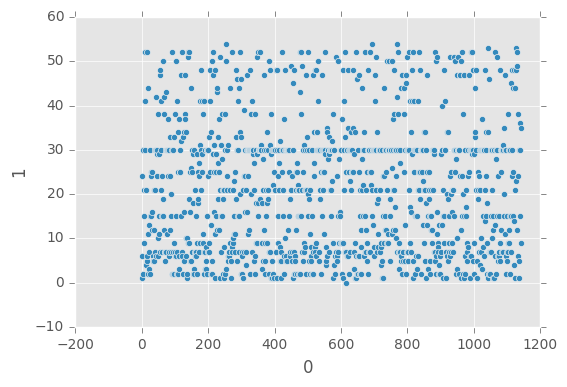

In [51]:
# this is a cluseter of the already-clustered kmeans topics; not very informative
plt.figure()
df_clusters.plot.scatter(x=0, y=1)  # y is topics no., x is doc id

## Kmeans based tfidf matrix

In [52]:
# try clustering the original tfidf
# tfidf_dense = tfidf.toarray()
scaler = preprocessing.StandardScaler(with_mean=False).fit(tfidf) # either with_mean=False or make dense

# save scaler
scaler_fp = os.path.expanduser('~/cltk_data/user_data/tlg_lemmatized_no_accents_no_stops_tfidf_{0}features_scaler.pickle'.format(n_features))
joblib.dump(df_scaled, scaler_fp)

['/root/cltk_data/user_data/tlg_lemmatized_no_accents_no_stops_tfidf_1000features_scaler.pickle']

In [53]:
import numpy as np

In [54]:
# direct Pandas conversion of sparse scipy matrix not supported
# Following http://stackoverflow.com/a/17819427
# df_scaled_tfidf = pandas.DataFrame(scaler.transform(tfidf))
# df_scaled_tfidf = pandas.DataFrame()

t0 = dt.datetime.utcnow()

scaler_tfidf = scaler.transform(tfidf)  # sparse matrix of type '<class 'numpy.float64'>
pandas.SparseDataFrame([pandas.SparseSeries(scaler_tfidf[i].toarray().ravel()) for i in np.arange(scaler_tfidf.shape[0])])
df_scaled_tfidf = pandas.SparseDataFrame([pandas.SparseSeries(scaler_tfidf[i].toarray().ravel()) for i in np.arange(scaler_tfidf.shape[0])])
# type(df)  # pandas.sparse.frame.SparseDataFrame

print('... finished in {}'.format(dt.datetime.utcnow() - t0))

In [55]:
t0 = dt.datetime.utcnow()

# Convert DataFrame to matrix (numpy.ndarray)
matrix_tfidf = df_scaled_tfidf.as_matrix()

km_tfidf = cluster.KMeans(n_clusters=n_topics)
km_tfidf.fit(matrix_tfidf)

# Get cluster assignment labels
labels = km_tfidf.labels_  # these are the topics 0-54; array([53, 53, 16, ..., 42, 16, 13]

# Format results as a DataFrame
df_clusters_tfidf = pandas.DataFrame([df_scaled_tfidf.index, labels]).T  # add author names to the 0 col

print('... finished in {}'.format(dt.datetime.utcnow() - t0))

In [56]:
df_clusters_tfidf.head(10)

,0,1
0,0,33
1,1,33
2,2,28
3,3,31
4,4,13
5,5,14
6,6,14
7,7,51
8,8,3
9,9,30


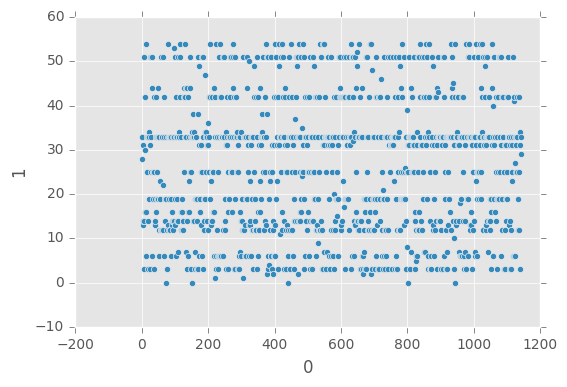

In [57]:
plt.figure()
df_clusters_tfidf.plot.scatter(x=0, y=1)  # y is topics no., x is doc id

## Kmeans based on nmf

In [58]:
nmf_array = nmf.components_

In [59]:
t0 = dt.datetime.utcnow()

# nmf_dense = nmf_array.toarray()
scaler = preprocessing.StandardScaler().fit(nmf_array) # either with_mean=False or make dense

# save features
tfidf_matrix_scaler_fp = os.path.expanduser('~/cltk_data/user_data/tlg_lemmatized_no_accents_no_stops_tfidf_matrix_{0}features.pickle'.format(n_features))
joblib.dump(scaler, tfidf_matrix_scaler_fp)

print('... finished in {}'.format(dt.datetime.utcnow() - t0))

... finished in 0:00:00.006931


In [60]:
df_scaled_nmf = pandas.DataFrame(scaler.transform(nmf_array))

In [61]:
# Convert DataFrame to matrix (numpy.ndarray)
matrix_nmf = df_scaled_nmf.as_matrix()

km_nmf = cluster.KMeans(n_clusters=n_topics)
km_nmf.fit(matrix_nmf)

# Get cluster assignment labels
labels = km_nmf.labels_  # these are the clusters 0-54; array([ 1,  4, 11, 14, 28,  9, 30,

# Format results as a DataFrame
df_clusters_nmf = pandas.DataFrame([df_scaled_nmf.index, labels]).T  # add author names to the 0 col

In [62]:
df_clusters_nmf.head(10)

,0,1
0,0,1
1,1,7
2,2,5
3,3,8
4,4,4
5,5,2
6,6,16
7,7,25
8,8,29
9,9,12


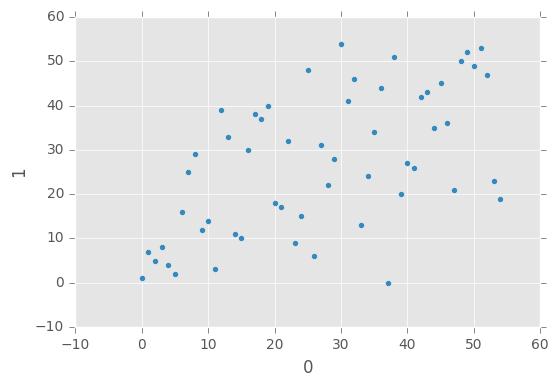

In [63]:
plt.figure()
df_clusters_nmf.plot.scatter(x=0, y=1)  #axis?